guide
https://pytorch.org/hub/nvidia_deeplearningexamples_ssd/

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /home/jeff/.cache/torch/hub/torchhub.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jeff/.cache/torch/checkpoints/resnet50-19c8e357.pth
24.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

62.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


In [5]:
# ! pip install scipy scikit-image

     |████████████████████████████████| 25.9 MB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 1.1 MB/s  eta 0:00:01
     |████████████████████████████████| 4.4 MB 28.0 MB/s eta 0:00:01
     |████████████████████████████████| 148 kB 27.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 31.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 27.3 MB/s eta 0:00:01


In [6]:
# For convenient and comprehensive formatting of input and output of the model, load a set of utility methods.
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /home/jeff/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [7]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [10]:
image_path = ['data/images/00011801_001.png', 'data/images/00013993_006.png']

In [11]:
image_path

['data/images/00011801_001.png', 'data/images/00013993_006.png']

In [12]:
# Format the images to comply with the network input and convert them to tensor.
inputs = [utils.prepare_input(ip) for ip in image_path]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

In [16]:
tensor.shape

torch.Size([2, 3, 300, 300])

In [17]:
# Run the SSD network to perform object detection.
with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [18]:
# By default, raw output from SSD network per input image contains 8732 boxes with localization 
# and class probability distribution. 
# Let’s filter this output to only get reasonable detections (confidence>40%) in a more comprehensive format.

results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

In [19]:
best_results_per_input

[[array([[0.0040262 , 0.01648715, 0.9967381 , 0.9915403 ]], dtype=float32),
  array([60]),
  array([0.8664965], dtype=float32)],
 [array([[0.00277656, 0.02230236, 0.993521  , 0.9932977 ]], dtype=float32),
  array([60]),
  array([0.76502496], dtype=float32)]]

In [20]:
# The model was trained on COCO dataset
classes_to_labels = utils.get_coco_object_dictionary()

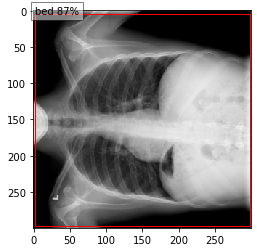

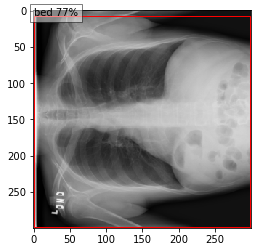

In [21]:
# Finally, let’s visualize our detections

from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()